In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
datadir = "/content/drive/My Drive/CS444/EC"

os.chdir(datadir)
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS444/EC


In [ ]:
!tar zxvf imagenette2-320.tgz
!ls

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data


In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [4]:
from torchvision.transforms.transforms import Compose
from tqdm import tqdm
# Define the device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# model define
model = models.inception_v3(weights='IMAGENET1K_V1').to(device)

model.eval()

# Init Dataset

transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

classes_S = [0,217,482,491,497,566,569,571,574,701]
testing = datasets.ImageFolder(root = '/content/drive/My Drive/CS444/EC/imagenette2-320/val/',transform = transform)
print(testing.classes)
testing,_ = torch.utils.data.random_split(testing, [1000, len(testing)-1000])

loader = Data.DataLoader(testing, batch_size=1, shuffle=True)

CUDA Available:  False
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [5]:
def fgsm_attack(image, epsilon, data_grad):

    perturbed_image = image + epsilon*data_grad.sign()
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [6]:
def test( model, device, test_loader, epsilon ):

    correct = 0

    for data, target in tqdm(test_loader):

        data, target = data.to(device), target.to(device)
        data.requires_grad = True


        output = model(data)
        _ , init_pred = torch.max(output.data,1)

        if init_pred!=classes_S[target]:
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()

        perturbed_data = fgsm_attack(data, epsilon, data.grad.data)
        output = model(perturbed_data)
   
        _ , pre = torch.max(output.data,1)
        correct +=(pre==classes_S[target]).sum()

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc.detach().cpu()

In [97]:
fsgm_accuracies = []

for eps in epsilons:
    acc = test(model, device, loader, eps)
    fsgm_accuracies.append(acc)


100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s]


Epsilon: 0	Test Accuracy = 772 / 1000 = 0.7720000147819519


100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


Epsilon: 0.05	Test Accuracy = 345 / 1000 = 0.3450000286102295


100%|██████████| 1000/1000 [00:52<00:00, 18.97it/s]


Epsilon: 0.1	Test Accuracy = 230 / 1000 = 0.23000000417232513


100%|██████████| 1000/1000 [00:53<00:00, 18.85it/s]


Epsilon: 0.15	Test Accuracy = 152 / 1000 = 0.15200001001358032


100%|██████████| 1000/1000 [00:52<00:00, 19.17it/s]


Epsilon: 0.2	Test Accuracy = 98 / 1000 = 0.09800000488758087


100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]


Epsilon: 0.25	Test Accuracy = 50 / 1000 = 0.05000000074505806


100%|██████████| 1000/1000 [00:50<00:00, 19.66it/s]

Epsilon: 0.3	Test Accuracy = 21 / 1000 = 0.021000001579523087


In [7]:
#referenced from https://github.com/Harry24k/AEPW-pytorch/blob/master/Adversarial%20examples%20in%20the%20physical%20world.ipynb

def iter_(model, images, labels, eps, alpha) :
    images = images.to(device)
    labels = labels.to(device)
    
    # min(eps + 4, 1.25*eps) was used in the paper but I did some modifications for time computing wise
    iters = int(min((eps*255) + 4, 1.25*eps*255)/5)
    
    for _ in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = F.nll_loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{1, c}
        images = torch.clamp(c, max=1).detach_()
            
    return images

In [8]:
def test_iter(model, device, test_loader, epsilon):
    correct = 0
    for data, target in tqdm(test_loader):
        
        perturbed_data = iter_(model,data,target,epsilon,.005)

        output = model(perturbed_data)
      
        _ , pre = torch.max(output.data,1)
        correct +=(pre==classes_S[target]).sum()

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc.detach().cpu()

In [100]:
iter_accuracies = []

for eps in epsilons:
    print(int(min((eps*255) + 4, 1.25*eps*255)/5))
    acc = test_iter(model, device, loader, eps)
    iter_accuracies.append(acc)

0


100%|██████████| 1000/1000 [00:24<00:00, 40.08it/s]


Epsilon: 0	Test Accuracy = 772 / 1000 = 0.7720000147819519
3


100%|██████████| 1000/1000 [02:07<00:00,  7.86it/s]


Epsilon: 0.05	Test Accuracy = 443 / 1000 = 0.44300001859664917
5


100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Epsilon: 0.1	Test Accuracy = 303 / 1000 = 0.30300000309944153
8


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


Epsilon: 0.15	Test Accuracy = 187 / 1000 = 0.18700000643730164
11


100%|██████████| 1000/1000 [06:15<00:00,  2.66it/s]


Epsilon: 0.2	Test Accuracy = 149 / 1000 = 0.14900000393390656
13


100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s]


Epsilon: 0.25	Test Accuracy = 115 / 1000 = 0.11500000208616257
16


100%|██████████| 1000/1000 [09:07<00:00,  1.83it/s]

Epsilon: 0.3	Test Accuracy = 90 / 1000 = 0.09000000357627869


In [9]:
def ll_class_attack(model, images, eps) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
    
    images.requires_grad = True
    outputs = model(images)

    model.zero_grad()
    cost = F.nll_loss(outputs, labels).to(device)
    cost.backward()

    images = images - eps*images.grad.sign()

    images = torch.clamp(images,0,1)
    
    return images

In [10]:
def test_llc(model, device, test_loader, epsilon):
    correct = 0
    for data, target in tqdm(test_loader):

        perturbed_data = ll_class_attack(model,data,epsilon)

        output = model(perturbed_data)
      
        _ , pre = torch.max(output.data,1)
        correct +=(pre==classes_S[target]).sum()

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc.detach().cpu()

In [103]:
llc_accuracies = []

for eps in epsilons:
    acc = test_llc(model, device, loader, eps)
    llc_accuracies.append(acc)

100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s]


Epsilon: 0	Test Accuracy = 772 / 1000 = 0.7720000147819519


100%|██████████| 1000/1000 [01:15<00:00, 13.20it/s]


Epsilon: 0.05	Test Accuracy = 433 / 1000 = 0.43300002813339233


100%|██████████| 1000/1000 [01:15<00:00, 13.32it/s]


Epsilon: 0.1	Test Accuracy = 312 / 1000 = 0.31200000643730164


100%|██████████| 1000/1000 [01:16<00:00, 13.03it/s]


Epsilon: 0.15	Test Accuracy = 191 / 1000 = 0.19100001454353333


100%|██████████| 1000/1000 [01:15<00:00, 13.20it/s]


Epsilon: 0.2	Test Accuracy = 101 / 1000 = 0.10100000351667404


100%|██████████| 1000/1000 [01:16<00:00, 13.07it/s]


Epsilon: 0.25	Test Accuracy = 42 / 1000 = 0.04200000315904617


100%|██████████| 1000/1000 [01:15<00:00, 13.26it/s]

Epsilon: 0.3	Test Accuracy = 21 / 1000 = 0.021000001579523087


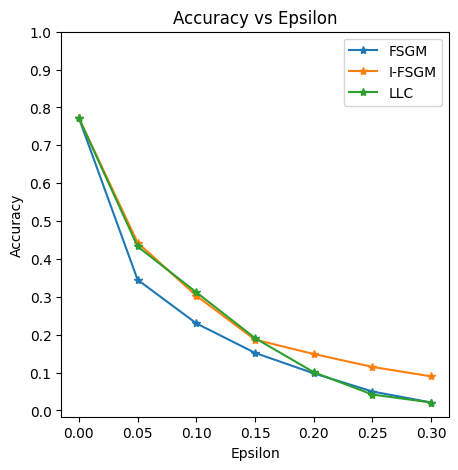

In [104]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, fsgm_accuracies, "*-",label="FSGM")
plt.plot(epsilons, iter_accuracies, "*-",label="I-FSGM")
plt.plot(epsilons, llc_accuracies, "*-",label="LLC")
plt.legend()
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [11]:
image,target = next(iter(loader))
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()
